# Titanic
![](https://i.imgur.com/rRFchA8.png)

## 目次
0. ライブラリ・データ読み込み
1. 探索的データ分析 (EDA)
2. データの前処理・特徴量エンジニアリング
3. ランダムフォレストモデル構築
4. 提出ファイル作成

## 0\. ライブラリ・データ読み込み


### 0.1 ライブラリのインストール・インポート

In [ ]:
# !pip install optuna

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
# import optuna

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble, model_selection

import warnings
warnings.filterwarnings("ignore")

### 0.2 trainとtestデータの読み込み

In [ ]:
# ファイルをセッションストレージにアップロード
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

### 0.3 trainとtestデータを結合

In [ ]:
df_all = pd.concat([df, df_test], ignore_index=True)
print(df_all.shape)
df_all.tail()

(1309, 12)


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## 1\. 探索的データ分析 (EDA)

### 1.1 データの外観

In [ ]:
# データサイズを確認
print(f"訓練データ \n  データ数: {df.shape[0]}  変数の種類: {df.shape[1]}")
print(f"テストデータ \n  データ数: {df_test.shape[0]}  変数の種類: {df_test.shape[1]}")

訓練データ 
  データ数: 891  変数の種類: 12
テストデータ 
  データ数: 418  変数の種類: 11


In [ ]:
# trainデータの先頭5行を表示
df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.2 各特徴量の型や意味

In [ ]:
# trainデータの型を確認
df.dtypes

PassengerId      int64
Perished         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

各特徴量の詳細

特徴量 |定義 |備考  
---|---|---
Perished |死亡したかどうか |0 = No, 1 = Yes
Pclass |チケットのクラス |1 = 1st, 2 = 2nd, 3 = 3rd
Name |名前 |
Sex |性別 |
Age	|年齢 |
SibSp |乗船していた兄弟姉妹・配偶者の数	|
Parch |乗船していた親・子供の数	|
Ticket |チケット番号	|
Fare |チケット料金	|
Cabin |キャビン番号	|
Embarked |乗船した港	|C = Cherbourg, Q = Queenstown, S = Southampton

### 1.3 各特徴量の統計量

In [ ]:
# trainデータの統計量
df.describe()

,PassengerId,Perished,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.616162,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,1.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.4 各特徴量の相関関係

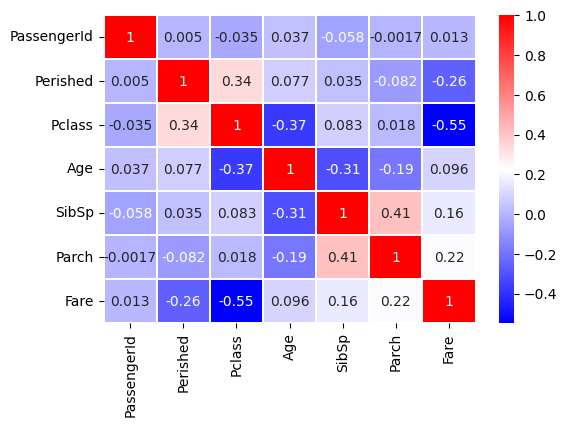

In [ ]:
# trainデータの相関行列のヒートマップ
sns.heatmap(df.corr(), annot=True, cmap="bwr", linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(6, 4)
plt.show()

知見  
・SibSp (siblings/spouse) とParch (parent/child) の相関が強い  
・Pclassの値が小さいほどチケットのグレードが高い

### 1.5 欠損値の確認

In [ ]:
# trainデータの欠損値を確認
df.isnull().sum()

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# testデータの欠損値を確認
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 1.6 分布の可視化

#### 1.6.1 データ全体の生死

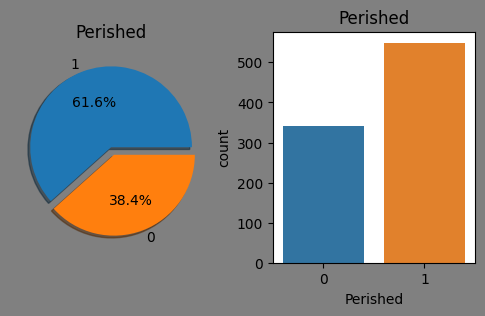

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(6, 3), facecolor="gray")
f.subplots_adjust(wspace=0.3)
df["Perished"].value_counts().plot.pie(explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title("Perished")
ax[0].set_ylabel("")
sns.countplot(x="Perished", data=df, ax=ax[1])
ax[1].set_title("Perished")
plt.show()

#### 1.6.2 性別ごとの人数と死亡率

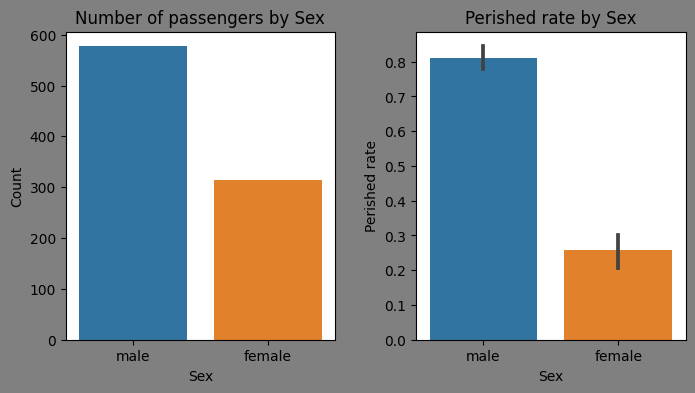

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="Sex", data=df, ax=ax[0])
ax[0].set_title("Number of passengers by Sex")
ax[0].set_ylabel("Count")
sns.barplot(x="Sex", y="Perished", data=df, ax=ax[1])
ax[1].set_title("Perished rate by Sex", fontsize=12)
ax[1].set_ylabel("Perished rate")
plt.show()

In [ ]:
df[["Sex", "Perished"]].groupby(["Sex"], as_index=True).mean()

,Perished
Sex,
female,0.257962
male,0.811092


知見  
・男性の方が女性より多い  
・男性の死亡率は高いが、女性の死亡率は低い

#### 1.6.3 チケットクラスごとの人数と死亡率

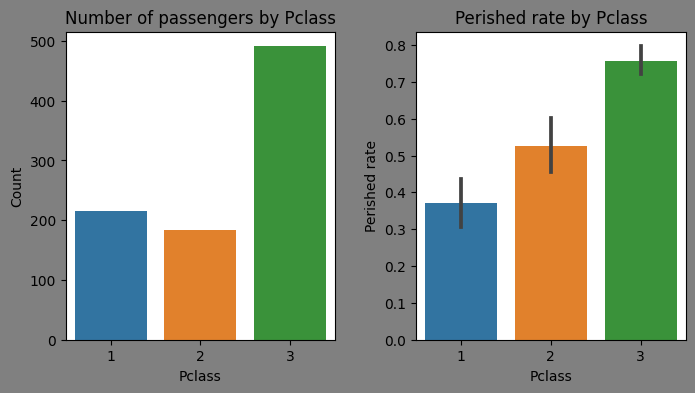

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="Pclass", data=df, ax=ax[0])
ax[0].set_title("Number of passengers by Pclass")
ax[0].set_ylabel("Count")
sns.barplot(x="Pclass", y="Perished", data=df, ax=ax[1])
ax[1].set_title("Perished rate by Pclass", fontsize=12)
ax[1].set_ylabel("Perished rate")
plt.show()

In [ ]:
df[["Pclass", "Perished"]].groupby(["Pclass"], as_index=True).mean()

,Perished
Pclass,
1,0.370370
2,0.527174
3,0.757637


知見  
・チケットクラス3は人数が圧倒的に多い  
・チケットクラスが大きいほど死亡率は増加

#### 1.6.4 チケット料金と生死

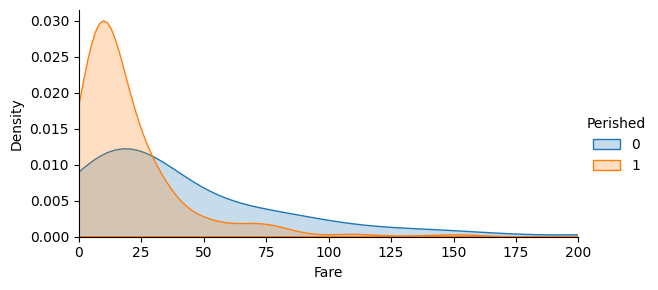

In [ ]:
fare = sns.FacetGrid(df, hue="Perished", aspect=2)
fare.map(sns.kdeplot, "Fare", shade=True)
fare.set(xlim=(0, 200))
fare.add_legend()
plt.show()

知見  
・チケット料金が安いほど死亡率が高い

#### 1.6.5 年齢と生死

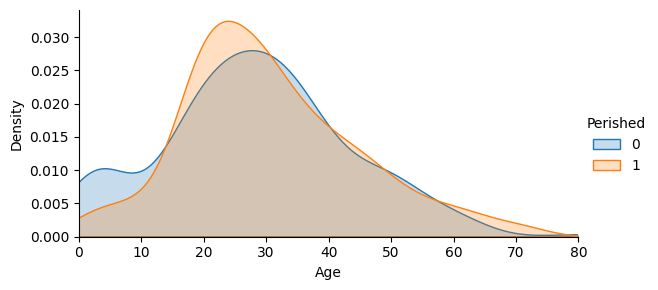

In [ ]:
age = sns.FacetGrid(df, hue="Perished", aspect=2)
age.map(sns.kdeplot, "Age", shade=True)
age.set(xlim=(0, df["Age"].max()))
age.add_legend()
plt.show()

知見  
・10歳以下の子供は死亡率が低い  
・20代の死亡者数が多い  
・65歳超えは死亡率が高い

## 2\. データの前処理・特徴量エンジニアリング


### 2.1 欠損値の補完

#### 2.1.1 "Age"列

In [ ]:
# "Name"列から敬称を抽出し、"Title"列を作成
df["Title"] = df["Name"].str.extract(r"([A-Za-z]+)\.")
df_test["Title"] = df_test["Name"].str.extract(r"([A-Za-z]+)\.")
df_all["Title"] = df_all["Name"].str.extract(r"([A-Za-z]+)\.")

In [ ]:
# 敬称ごとの平均年齢
mean_age_by_title = df_all.groupby("Title")["Age"].mean()
print(mean_age_by_title)

Title
Capt        70.000000
Col         54.000000
Countess    33.000000
Don         40.000000
Dona        39.000000
Dr          43.571429
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       5.482642
Miss        21.774238
Mlle        24.000000
Mme         24.000000
Mr          32.252151
Mrs         36.994118
Ms          28.000000
Rev         41.250000
Sir         49.000000
Name: Age, dtype: float64


In [ ]:
# 敬称ごとの平均年齢で補完
# 年齢にばらつきがある敬称が精度を下げる原因に
# df["Age"].fillna(df["Title"].map(mean_age_by_title), inplace=True)
# df_test["Age"].fillna(df_test["Title"].map(mean_age_by_title), inplace=True)
# df_all["Age"].fillna(df_all["Title"].map(mean_age_by_title), inplace=True)

In [ ]:
# "Pclass", "Sex", "Title"からランダムフォレスト回帰で"Age"の欠損値を補完
age_df = df_all[["Age", "Pclass", "Sex", "Title"]]

# カテゴリ変数をダミー変数化
age_df = pd.get_dummies(age_df)

age_df.head()

,Age,Pclass,Sex_female,Sex_male,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dona,Title_Dr,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,3,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# "Age"が欠損していない行（学習データ）と欠損している行を分割
known_age = age_df[age_df["Age"].notnull()].values
unknown_age = age_df[age_df["Age"].isnull()].values

# 学習データの説明変数と目的変数
X_age = known_age[:, 1:]
y_age = known_age[:, 0]

# ランダムフォレストの回帰モデルを構築
rfr_age = RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1)
rfr_age.fit(X_age, y_age)

# "Age"が欠損している行の"Age"を予測
predict_age = rfr_age.predict(unknown_age[:, 1:])

# trainデータの欠損している"Age"を補完
train_age_null_size = df["Age"].isnull().sum()
df.loc[(df["Age"].isnull()), "Age"] = predict_age[:train_age_null_size]

# testデータの欠損している"Age"を補完
df_test.loc[(df_test["Age"].isnull()), "Age"] = predict_age[train_age_null_size:]

# 全データの欠損している"Age"を補完
df_all.loc[(df_all["Age"].isnull()), "Age"] = predict_age

#### 2.1.2 "Fare"列

In [ ]:
# "Fare"列の欠損行を抽出
df_test[df_test["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


In [ ]:
# チケットクラス3、出港地"S"の中央値で補完
fare_median = df_all[(df_all["Embarked"] == "S") & (df_all["Pclass"] == 3)]["Fare"].median()
df_test["Fare"].fillna(fare_median, inplace=True)
df_all["Fare"].fillna(fare_median, inplace=True)

#### 2.1.3 "Cabin"列

In [ ]:
# "Unknown"で補完
df["Cabin"] = df["Cabin"].fillna("Unknown")
df_test["Cabin"] = df_test["Cabin"].fillna("Unknown")
df_all["Cabin"] = df_all["Cabin"].fillna("Unknown")

#### 2.1.4 "Embarked"列

In [ ]:
# "Embarked"列の欠損行を抽出
df[df["Embarked"].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


In [ ]:
# 出港地別の料金の中央値（チケットクラス1）
c_median = df[(df["Embarked"] == "C") & (df["Pclass"] == 1)]["Fare"].median()
s_median = df[(df["Embarked"] == "S") & (df["Pclass"] == 1)]["Fare"].median()
q_median = df[(df["Embarked"] == "Q") & (df["Pclass"] == 1)]["Fare"].median()

print(f"出港地Cの中央値: {c_median}")
print(f"出港地Sの中央値: {s_median}")
print(f"出港地Qの中央値: {q_median}")

出港地Cの中央値: 78.2667
出港地Sの中央値: 52.0
出港地Qの中央値: 90.0


In [ ]:
# "C"で補完
df["Embarked"].fillna("C", inplace=True)
df_all["Embarked"].fillna("C", inplace=True)

### 2.2 特徴量の作成

#### 2.2.1 "Title"列

In [ ]:
# "Name"列から敬称を抽出し、"Title"列を追加
df["Title"] = df["Name"].str.extract(r"([A-Za-z]+)\.")
df_test["Title"] = df_test["Name"].str.extract(r"([A-Za-z]+)\.")
df_all["Title"] = df_all["Name"].str.extract(r"([A-Za-z]+)\.")

#### 2.2.2 "Surname"列

In [ ]:
# "Name"列から名字を抽出
df["Surname"] = df["Name"].map(lambda x: x.split(",")[0].strip())
df_test["Surname"] = df_test["Name"].map(lambda x: x.split(",")[0].strip())
df_all["Surname"] = df_all["Name"].map(lambda x: x.split(",")[0].strip())

#### 2.2.3 "FamilyGroup"列

In [ ]:
# 同じ名字を持つ家族グループ
df["FamilyGroup"] = df["Surname"].map(df["Surname"].value_counts())
df_test["FamilyGroup"] = df_test["Surname"].map(df_test["Surname"].value_counts())
df_all["FamilyGroup"] = df_all["Surname"].map(df_all["Surname"].value_counts())

In [ ]:
# 家族で子供(16才以下)または女性のグループ
female_child_group_df = df_all.loc[(df_all["FamilyGroup"] >= 2) & ((df_all["Age"] <= 16) | (df_all["Sex"] == "female"))]
# 上記のグループで名字ごとの死亡率
female_child_group_list = female_child_group_df.groupby("Surname")["Perished"].mean()

# 名字ごとの死亡率分布
print(female_child_group_list.value_counts())

0.000000    114
1.000000     32
0.250000      2
0.500000      1
0.666667      1
0.857143      1
Name: Perished, dtype: int64


知見  
・子供と女性グループは多くが死亡率0%である一方、一部では死亡率100%

In [ ]:
# 家族で大人の男性(16才超え)のグループ
male_adult_group_df = df_all.loc[(df_all["FamilyGroup"] >= 2) & (df_all["Age"] > 16) & (df_all["Sex"] == "male")]
# 上記のグループで名字ごとの死亡率
male_adult_group_list = male_adult_group_df.groupby("Surname")["Perished"].mean()

# 名字ごとの死亡率分布
print(male_adult_group_list.value_counts())

1.000000    117
0.000000     20
0.500000      6
0.666667      2
0.750000      1
Name: Perished, dtype: int64


知見  
・大人の男性グループは多くが死亡率100%である一方、一部では死亡率0%

In [ ]:
# 子供と女性グループで死亡率100%の名字リスト
dead_list = set(female_child_group_list[female_child_group_list.apply(lambda x: x == 1)].index)
print(dead_list)

{'Goodwin', 'Oreskovic', 'Van Impe', 'Palsson', 'Caram', 'Ilmakangas', 'Rosblom', 'Sage', 'Johnston', 'Rice', 'Ford', 'Skoog', 'Canavan', 'Jussila', 'Attalah', 'Olsson', 'Robins', 'Lefebre', 'Strom', 'Lahtinen', 'Bourke', 'Arnold-Franchi', 'Lobb', 'Elias', 'Cacic', 'Danbom', 'Turpin', 'Boulos', 'Zabour', 'Barbara', 'Vander Planke', 'Panula'}


In [ ]:
# 大人の男性グループで死亡率0%の名字リスト
survived_list = set(male_adult_group_list[male_adult_group_list.apply(lambda x: x == 0)].index)
print(survived_list)

{'Greenfield', 'Taylor', 'Goldenberg', 'Frauenthal', 'Harder', 'Jussila', 'Nakid', 'Bishop', 'Duff Gordon', 'Chambers', 'Daly', 'McCoy', 'Cardeza', 'Dick', 'Kimball', 'Frolicher-Stehli', 'Bradley', 'Beckwith', 'Beane', 'Jonsson'}


In [ ]:
# テストデータの中でデッドリストに該当した場合、2.2.11で得られた典型的な死亡データに書き換え
df_test.loc[df_test["Surname"].apply(lambda x: x in dead_list), ["Sex", "Age", "Title"]] = ["male", 66, "Mr"]

# テストデータの中でサバイブリストに該当した場合、2.2.11で得られた典型的な生存データに書き換え
df_test.loc[df_test["Surname"].apply(lambda x: x in survived_list), ["Sex", "Age", "Title"]] = ["female", 61, "Miss"]

#### 2.2.4 "SibSpLabel"列

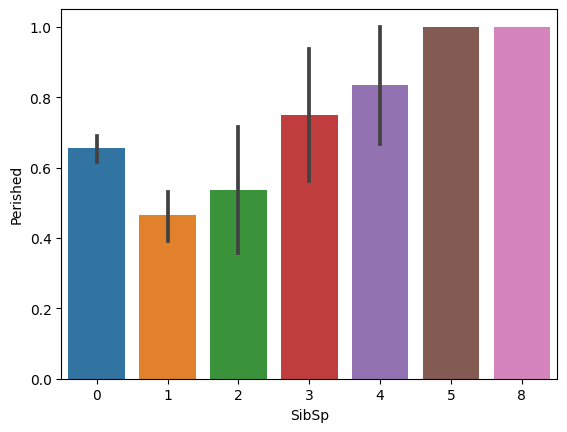

In [ ]:
# "SibSp"別の死亡率
sns.barplot(x="SibSp", y="Perished", data=df)
plt.show()

In [ ]:
# "SibSp"別の死亡率でグループ分け
def sibsp_label(sibsp):
    if (0 <= sibsp <= 3):
        return 0
    elif (sibsp >= 4):
        return 1

df["SibSpLabel"] = df["SibSp"].apply(sibsp_label)
df_test["SibSpLabel"] = df_test["SibSp"].apply(sibsp_label)
df_all["SibSpLabel"] = df_all["SibSp"].apply(sibsp_label)

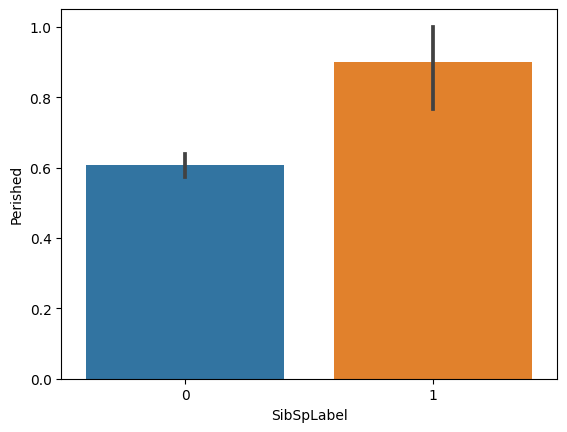

In [ ]:
# "SibSpLabel"別の死亡率
sns.barplot(x="SibSpLabel", y="Perished", data=df)
plt.show()

#### 2.2.5 "ParchLabel"列

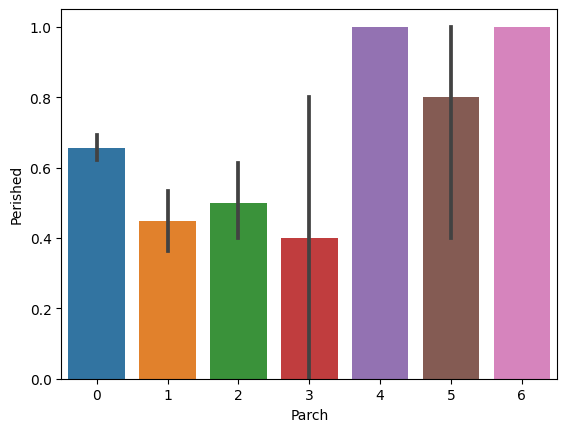

In [ ]:
# "Parch"別の死亡率
sns.barplot(x="Parch", y="Perished", data=df)
plt.show()

In [ ]:
# "Parch"別の死亡率でグループ分け
def parch_label(parch):
    if (1 <= parch <= 3):
        return 0
    elif (parch == 0):
        return 1
    elif (parch >= 4):
        return 2

df["ParchLabel"] = df["Parch"].apply(parch_label)
df_test["ParchLabel"] = df_test["Parch"].apply(parch_label)
df_all["ParchLabel"] = df_all["Parch"].apply(parch_label)

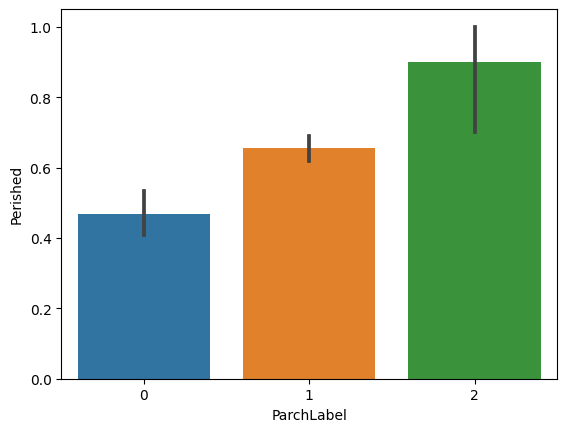

In [ ]:
# "ParchLabel"別の死亡率
sns.barplot(x="ParchLabel", y="Perished", data=df)
plt.show()

#### 2.2.6 "FamilySize"列

In [ ]:
# 家族の大きさ
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df_test["FamilySize"] = df_test["SibSp"] + df_test["Parch"] + 1
df_all["FamilySize"] = df_all["SibSp"] + df_all["Parch"] + 1

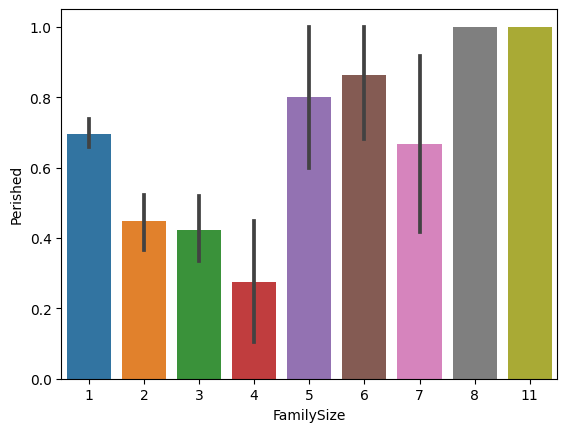

In [ ]:
# "FamilySize"別の死亡率
sns.barplot(x="FamilySize", y="Perished", data=df)
plt.show()

In [ ]:
df[["FamilySize", "Perished"]].groupby(["FamilySize"], as_index=True).mean().sort_values(by="Perished")

,Perished
FamilySize,
4,0.275862
3,0.421569
2,0.447205
7,0.666667
1,0.696462
5,0.800000
6,0.863636
8,1.000000
11,1.000000


#### 2.2.7 "FamilySizeLabel"列

In [ ]:
# "FamilySize"別の死亡率でグループ分け
def family_size_label(family_size):
    if (2 <= family_size <= 4):
        return 0
    elif ((family_size == 1) | (5 <= family_size <= 7)):
        return 1
    elif (family_size >= 8):
        return 2

df["FamilySizeLabel"] = df["FamilySize"].apply(family_size_label)
df_test["FamilySizeLabel"] = df_test["FamilySize"].apply(family_size_label)
df_all["FamilySizeLabel"] = df_all["FamilySize"].apply(family_size_label)

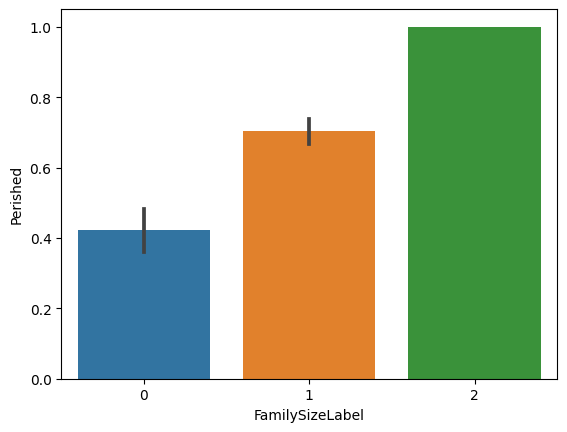

In [ ]:
# "FamilySizeLabel"別の死亡率
sns.barplot(x="FamilySizeLabel", y="Perished", data=df)
plt.show()

#### 2.2.8 "SameTicketGroup"列

In [ ]:
# 同じ種類のチケットを持っている人数
ticket_count = dict(df_all["Ticket"].value_counts())
df["SameTicketGroup"] = df["Ticket"].map(ticket_count)
df_test["SameTicketGroup"] = df_test["Ticket"].map(ticket_count)
df_all["SameTicketGroup"] = df_all["Ticket"].map(ticket_count)

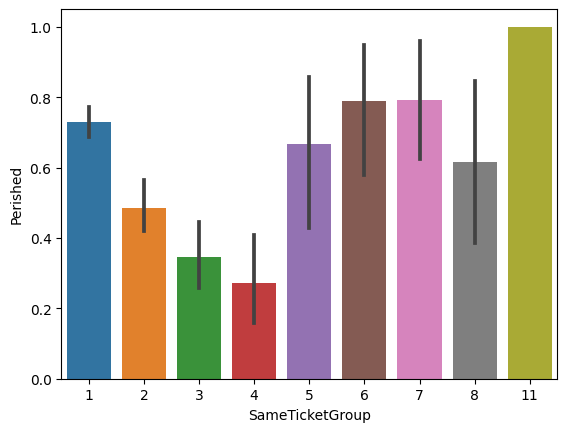

In [ ]:
# "SameTicketGroup"別の死亡率
sns.barplot(x="SameTicketGroup", y="Perished", data=df)
plt.show()

知見  
・チケットが同じ人は同じ部屋であり、一緒に行動し生死を共にしやすいと推測できる  
・チケットが同じ人の人数によって生死が変化

#### 2.2.9 "SameTicketLabel"列

In [ ]:
# "SameTicketGroup"別の死亡率でグループ分け
def same_ticket_label(same_ticket):
    if (2 <= same_ticket <= 4):
        return 0
    elif ((same_ticket == 1) | (5 <= same_ticket <= 8)):
        return 1
    elif (same_ticket >= 11):
        return 2

df["SameTicketLabel"] = df["SameTicketGroup"].apply(same_ticket_label)
df_test["SameTicketLabel"] = df_test["SameTicketGroup"].apply(same_ticket_label)
df_all["SameTicketLabel"] = df_all["SameTicketGroup"].apply(same_ticket_label)

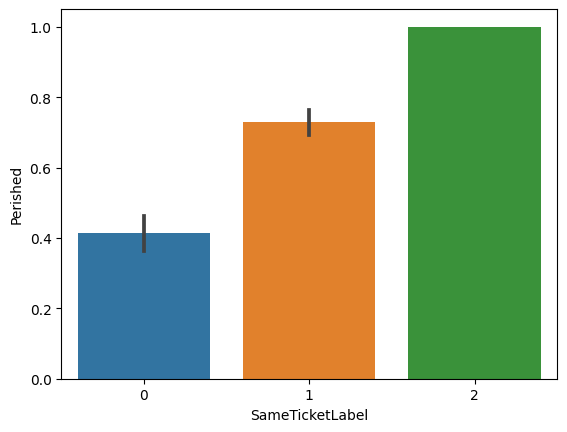

In [ ]:
# "SameTicketLabel"別の死亡率
sns.barplot(x="SameTicketLabel", y="Perished", data=df)
plt.show()

#### 2.2.10 "TicketLabel"列

In [ ]:
# 数字だけからなるチケット
number_ticket_df = df[df["Ticket"].str.match("\d+")].copy()
number_ticket_df_test = df_test[df_test["Ticket"].str.match("\d+")].copy()
number_ticket_df_all = df_all[df_all["Ticket"].str.match("\d+")].copy()

In [ ]:
# int型に変換
number_ticket_df["Ticket"] = number_ticket_df["Ticket"].apply(lambda x: int(x))
number_ticket_df_test["Ticket"] = number_ticket_df_test["Ticket"].apply(lambda x: int(x))
number_ticket_df_all["Ticket"] = number_ticket_df_all["Ticket"].apply(lambda x: int(x))

# チケット番号の昇順で並び替え
number_ticket_df.sort_values(by="Ticket", inplace=True)
number_ticket_df_test.sort_values(by="Ticket", inplace=True)
number_ticket_df_all.sort_values(by="Ticket", inplace=True)

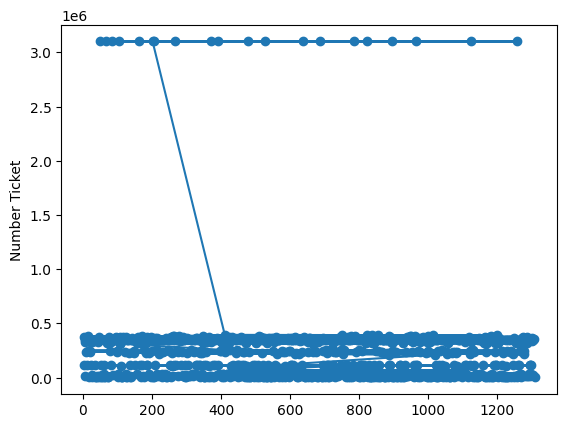

In [ ]:
# 数字だけからなるチケットの分布
plt.plot(number_ticket_df_all["Ticket"], "-o")
plt.ylabel("Number Ticket")
plt.show()

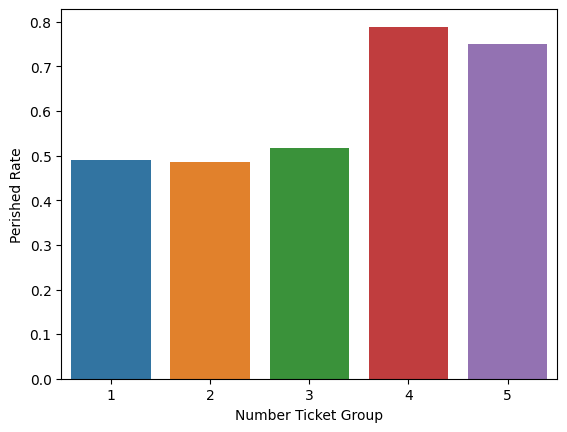

In [ ]:
# 数字だけのチケットを5グループに分割
number_ticket_df_1 = number_ticket_df[number_ticket_df["Ticket"] <= 1e5]
number_ticket_df_2 = number_ticket_df[(number_ticket_df["Ticket"] > 1e5) & (number_ticket_df["Ticket"] <= 2e5)]
number_ticket_df_3 = number_ticket_df[(number_ticket_df["Ticket"] > 2e5) & (number_ticket_df["Ticket"] <= 3e5)]
number_ticket_df_4 = number_ticket_df[(number_ticket_df["Ticket"] > 3e5) & (number_ticket_df["Ticket"] <= 4e5)]
number_ticket_df_5 = number_ticket_df[number_ticket_df["Ticket"] >= 3e6]

x = [1, 2, 3, 4, 5]
y = [number_ticket_df_1["Perished"].mean(), number_ticket_df_2["Perished"].mean(), number_ticket_df_3["Perished"].mean(), number_ticket_df_4["Perished"].mean(), number_ticket_df_5["Perished"].mean()]

sns.barplot(x=x, y=y)
plt.xlabel("Number Ticket Group")
plt.ylabel("Perished Rate")
plt.show()

知見  
・チケット番号によって死亡率が変化

In [ ]:
# アルファベットを含むチケット
number_alpha_ticket_df = df[df["Ticket"].str.match("[A-Z]+.+")].copy()
number_alpha_ticket_df_test = df_test[df_test["Ticket"].str.match("[A-Z]+.+")].copy()
number_alpha_ticket_df_all = df_all[df_all["Ticket"].str.match("[A-Z]+.+")].copy()

In [ ]:
# アルファベットを含むチケットの種類
print(sorted(number_alpha_ticket_df_all["Ticket"].value_counts().items()))

[('A. 2. 39186', 1), ('A./5. 2152', 1), ('A./5. 3235', 1), ('A./5. 3338', 1), ('A.5. 11206', 1), ('A.5. 18509', 1), ('A.5. 3236', 1), ('A/4 31416', 1), ('A/4 45380', 1), ('A/4 48871', 3), ('A/4 48873', 1), ('A/4. 20589', 1), ('A/4. 34244', 1), ('A/4. 39886', 1), ('A/5 1478', 1), ('A/5 21171', 1), ('A/5 21172', 1), ('A/5 21173', 1), ('A/5 21174', 1), ('A/5 21175', 1), ('A/5 2466', 1), ('A/5 2817', 1), ('A/5 3536', 1), ('A/5 3540', 1), ('A/5 3594', 1), ('A/5 3902', 1), ('A/5. 10482', 1), ('A/5. 13032', 1), ('A/5. 2151', 1), ('A/5. 3336', 2), ('A/5. 3337', 2), ('A/5. 851', 3), ('A/S 2816', 1), ('A4. 54510', 1), ('AQ/3. 30631', 1), ('AQ/4 3130', 1), ('C 17368', 1), ('C 17369', 1), ('C 4001', 3), ('C 7075', 1), ('C 7076', 1), ('C 7077', 1), ('C.A. 15185', 1), ('C.A. 17248', 1), ('C.A. 18723', 1), ('C.A. 2315', 4), ('C.A. 24579', 1), ('C.A. 24580', 1), ('C.A. 2673', 3), ('C.A. 29178', 1), ('C.A. 29395', 1), ('C.A. 29566', 1), ('C.A. 30769', 1), ('C.A. 31026', 1), ('C.A. 31029', 3), ('C.A. 31

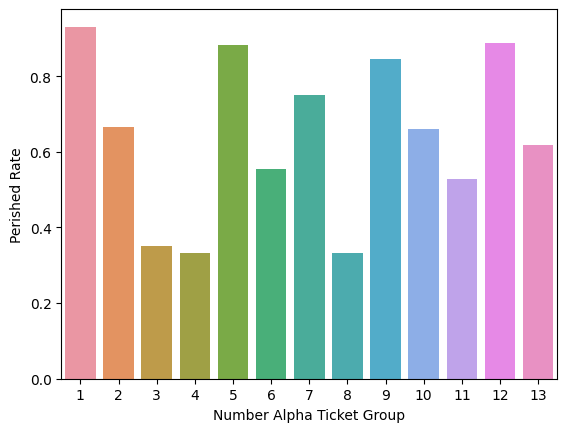

In [ ]:
# アルファベットを含むチケットを13グループに分割
A_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("A.+")]
CA_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("C\.*A\.*.+")]
PC_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("PC.+")]
PP_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("PP.+")]
SOTON_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("SOTON.+")]
STON_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("STON.+")]
LINE_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("LINE.*")]
FC_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("F\.C\.(C\.)*.+")]
W_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("W.+")]
C_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("C.+")]
SC_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("S(\.)*C.+")]
SO_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("S(\.)*O.+")]
other_ticket = number_alpha_ticket_df[number_alpha_ticket_df["Ticket"].str.match("(Fa)*(P/PP)*(S\.P)*(S\.*W)*.+")]

x = [i for i in range(1, 14)]
y = [
    A_ticket["Perished"].mean(), CA_ticket["Perished"].mean(), PC_ticket["Perished"].mean()
    ,PP_ticket["Perished"].mean(), SOTON_ticket["Perished"].mean(), STON_ticket["Perished"].mean()
    ,LINE_ticket["Perished"].mean(), FC_ticket["Perished"].mean(), W_ticket["Perished"].mean()
    ,C_ticket["Perished"].mean(), SC_ticket["Perished"].mean(), SO_ticket["Perished"].mean()
    ,other_ticket["Perished"].mean()
]

sns.barplot(x=x, y=y)
plt.xlabel("Number Alpha Ticket Group")
plt.ylabel("Perished Rate")
plt.show()

知見  
アルファベットを含むチケット番号によって死亡率が変化

In [ ]:
# trainデータの死亡率が高い順にラベリング
number_ticket_df.loc[number_ticket_df["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df.loc[number_ticket_df["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df.loc[number_ticket_df["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df.loc[(number_ticket_df["Ticket"] > 1e5) & (number_ticket_df["Ticket"] <= 2e5), "TicketLabel"] = 15
number_ticket_df.loc[(number_ticket_df["Ticket"] > 2e5) & (number_ticket_df["Ticket"] <= 3e5), "TicketLabel"] = 12
number_ticket_df.loc[(number_ticket_df["Ticket"] > 3e5) & (number_ticket_df["Ticket"] <= 4e5), "TicketLabel"] = 5
number_ticket_df.loc[number_ticket_df["Ticket"] >= 3e6, "TicketLabel"] = 6

number_alpha_ticket_df["TicketLabel"] = "13"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("A.+"), "TicketLabel"] = "1"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("C\.*A\.*.+"), "TicketLabel"] = "8"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("PC.+"), "TicketLabel"] = "16"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("PP.+"), "TicketLabel"] = "18"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("SOTON.+"), "TicketLabel"] = "3"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("STON.+"), "TicketLabel"] = "10"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("LINE.*"), "TicketLabel"] = "7"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("F\.C\.(C\.)*.+"), "TicketLabel"] = "17"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("W.+"), "TicketLabel"] = "4"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("C.+"), "TicketLabel"] = "9"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("S(\.)*C.+"), "TicketLabel"] = "11"
number_alpha_ticket_df.loc[number_alpha_ticket_df["Ticket"].str.match("S(\.)*O.+"), "TicketLabel"] = "2"

number_alpha_ticket_df["TicketLabel"] = number_alpha_ticket_df["TicketLabel"].apply(lambda x: int(x))
df = pd.concat([number_ticket_df, number_alpha_ticket_df])
df = df.sort_values(by="PassengerId")
df["TicketLabel"] = df["TicketLabel"].astype(int)

In [ ]:
# trainデータの死亡率が高い順にラベリング
number_ticket_df_test.loc[number_ticket_df_test["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df_test.loc[number_ticket_df_test["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df_test.loc[number_ticket_df_test["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df_test.loc[(number_ticket_df_test["Ticket"] > 1e5) & (number_ticket_df_test["Ticket"] <= 2e5), "TicketLabel"] = 15
number_ticket_df_test.loc[(number_ticket_df_test["Ticket"] > 2e5) & (number_ticket_df_test["Ticket"] <= 3e5), "TicketLabel"] = 12
number_ticket_df_test.loc[(number_ticket_df_test["Ticket"] > 3e5) & (number_ticket_df_test["Ticket"] <= 4e5), "TicketLabel"] = 5
number_ticket_df_test.loc[number_ticket_df_test["Ticket"] >= 3e6, "TicketLabel"] = 6

number_alpha_ticket_df_test["TicketLabel"] = "13"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("A.+"), "TicketLabel"] = "1"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("C\.*A\.*.+"), "TicketLabel"] = "8"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("PC.+"), "TicketLabel"] = "16"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("PP.+"), "TicketLabel"] = "18"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("SOTON.+"), "TicketLabel"] = "3"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("STON.+"), "TicketLabel"] = "10"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("LINE.*"), "TicketLabel"] = "7"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("F\.C\.(C\.)*.+"), "TicketLabel"] = "17"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("W.+"), "TicketLabel"] = "4"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("C.+"), "TicketLabel"] = "9"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("S(\.)*C.+"), "TicketLabel"] = "11"
number_alpha_ticket_df_test.loc[number_alpha_ticket_df_test["Ticket"].str.match("S(\.)*O.+"), "TicketLabel"] = "2"

number_alpha_ticket_df_test["TicketLabel"] = number_alpha_ticket_df_test["TicketLabel"].apply(lambda x: int(x))
df_test = pd.concat([number_ticket_df_test, number_alpha_ticket_df_test])
df_test = df_test.sort_values(by="PassengerId")
df_test["TicketLabel"] = df_test["TicketLabel"].astype(int)

In [ ]:
# trainデータの死亡率が高い順にラベリング
number_ticket_df_all.loc[number_ticket_df_all["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df_all.loc[number_ticket_df_all["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df_all.loc[number_ticket_df_all["Ticket"] <= 1e5, "TicketLabel"] = 14
number_ticket_df_all.loc[(number_ticket_df_all["Ticket"] > 1e5) & (number_ticket_df_all["Ticket"] <= 2e5), "TicketLabel"] = 15
number_ticket_df_all.loc[(number_ticket_df_all["Ticket"] > 2e5) & (number_ticket_df_all["Ticket"] <= 3e5), "TicketLabel"] = 12
number_ticket_df_all.loc[(number_ticket_df_all["Ticket"] > 3e5) & (number_ticket_df_all["Ticket"] <= 4e5), "TicketLabel"] = 5
number_ticket_df_all.loc[number_ticket_df_all["Ticket"] >= 3e6, "TicketLabel"] = 6

number_alpha_ticket_df_all["TicketLabel"] = "13"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("A.+"), "TicketLabel"] = "1"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("C\.*A\.*.+"), "TicketLabel"] = "8"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("PC.+"), "TicketLabel"] = "16"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("PP.+"), "TicketLabel"] = "18"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("SOTON.+"), "TicketLabel"] = "3"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("STON.+"), "TicketLabel"] = "10"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("LINE.*"), "TicketLabel"] = "7"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("F\.C\.(C\.)*.+"), "TicketLabel"] = "17"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("W.+"), "TicketLabel"] = "4"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("C.+"), "TicketLabel"] = "9"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("S(\.)*C.+"), "TicketLabel"] = "11"
number_alpha_ticket_df_all.loc[number_alpha_ticket_df_all["Ticket"].str.match("S(\.)*O.+"), "TicketLabel"] = "2"

number_alpha_ticket_df_all["TicketLabel"] = number_alpha_ticket_df_all["TicketLabel"].apply(lambda x: int(x))
df_all = pd.concat([number_ticket_df_all, number_alpha_ticket_df_all])
df_all = df_all.sort_values(by="PassengerId")
df_all["TicketLabel"] = df_all["TicketLabel"].astype(int)

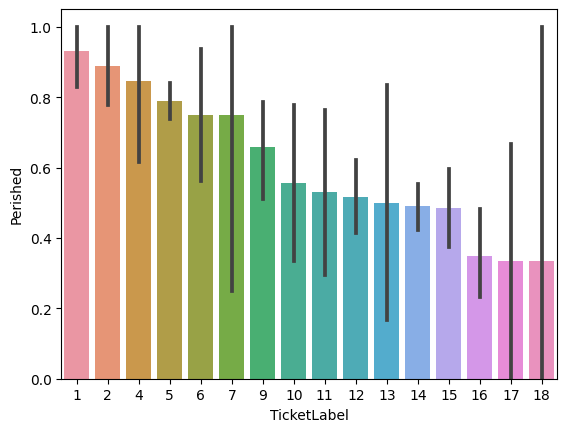

In [ ]:
# "TicketLable"別の死亡率
sns.barplot(x="TicketLabel", y="Perished", data=df)
plt.show()

#### 2.2.11 "AgeGroup"列

In [ ]:
# 年齢の最小値・最大値
print(f"Age min: {df_all['Age'].min()}")
print(f"Age max: {df_all['Age'].max()}")

Age min: 0.17
Age max: 80.0


In [ ]:
# 5歳ごとに分割
bins = [x for x in range(0, 81, 5)]

df["AgeGroup"] = pd.cut(df["Age"], bins=bins)
df_test["AgeGroup"] = pd.cut(df_test["Age"], bins=bins)
df_all["AgeGroup"] = pd.cut(df_all["Age"], bins=bins)

In [ ]:
df[df["Sex"] == "male"]["AgeGroup"].value_counts()

(25, 30]    162
(20, 25]     77
(30, 35]     67
(15, 20]     62
(40, 45]     50
(35, 40]     42
(45, 50]     26
(0, 5]       23
(50, 55]     16
(5, 10]      14
(55, 60]     12
(60, 65]     11
(10, 15]      7
(70, 75]      4
(65, 70]      3
(75, 80]      1
Name: AgeGroup, dtype: int64

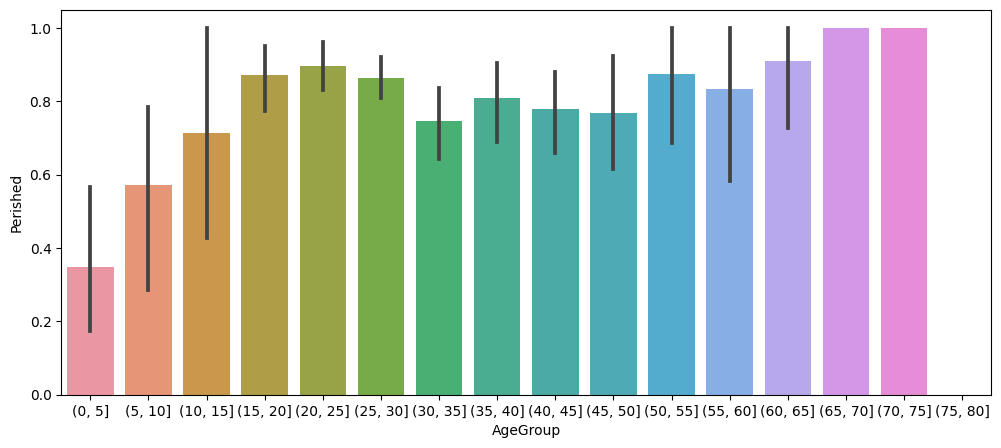

In [ ]:
# 男性年齢別の死亡率
plt.figure(figsize=(12, 5))
sns.barplot(x=df[df["Sex"] == "male"]["AgeGroup"], y="Perished", data=df)
plt.show()

In [ ]:
df[df["Sex"] == "female"]["AgeGroup"].value_counts()

(15, 20]    67
(20, 25]    47
(30, 35]    40
(25, 30]    36
(40, 45]    26
(35, 40]    25
(0, 5]      21
(45, 50]    13
(10, 15]    12
(5, 10]     10
(50, 55]     8
(55, 60]     6
(60, 65]     3
(65, 70]     0
(70, 75]     0
(75, 80]     0
Name: AgeGroup, dtype: int64

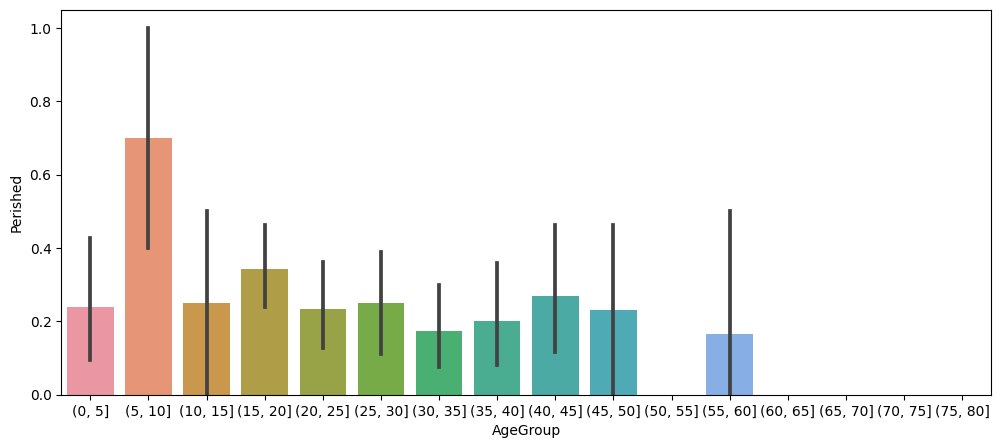

In [ ]:
# 女性年齢別の死亡率
plt.figure(figsize=(12, 5))
sns.barplot(x=df[df["Sex"] == "female"]["AgeGroup"], y="Perished", data=df)
plt.show()

知見  
・5歳以下は死亡率低い  
・65歳以上は死亡率高い

#### 2.2.12 "FareGroup"列

In [ ]:
# チケット料金の最小値・最大値
print(f"Fare min: {df_all['Fare'].min()}")
print(f"Fare max: {df_all['Fare'].max()}")

Fare min: 0.0
Fare max: 512.3292


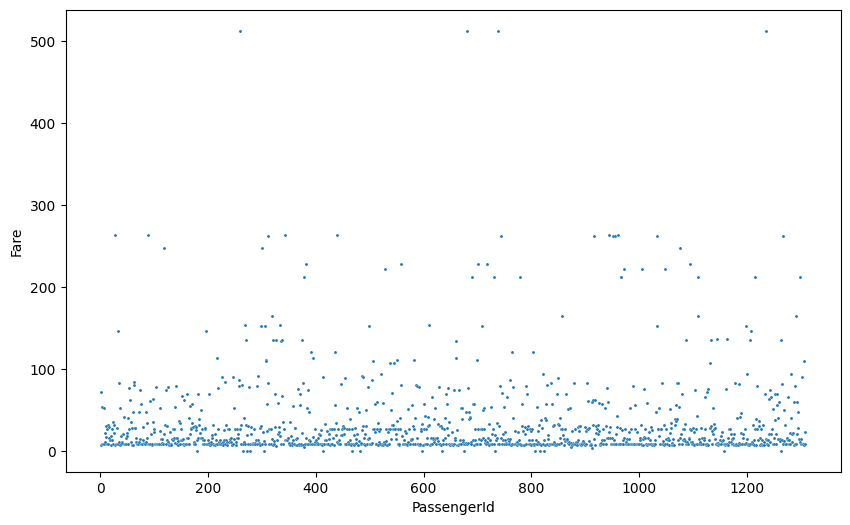

In [ ]:
# チケット料金の分布
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PassengerId", y="Fare", data=df_all, s=5)
plt.show()

In [ ]:
# 分割
bins = [0, 20, 40, 50, 60, 80, 100, 200, 300, 520]

df["FareGroup"] = pd.cut(df["Fare"], bins=bins, right=False)
df_test["FareGroup"] = pd.cut(df_test["Fare"], bins=bins, right=False)
df_all["FareGroup"] = pd.cut(df_all["Fare"], bins=bins, right=False)

In [ ]:
df["FareGroup"].value_counts()

[0, 20)       515
[20, 40)      200
[60, 80)       46
[50, 60)       39
[100, 200)     33
[80, 100)      23
[200, 300)     17
[40, 50)       15
[300, 520)      3
Name: FareGroup, dtype: int64

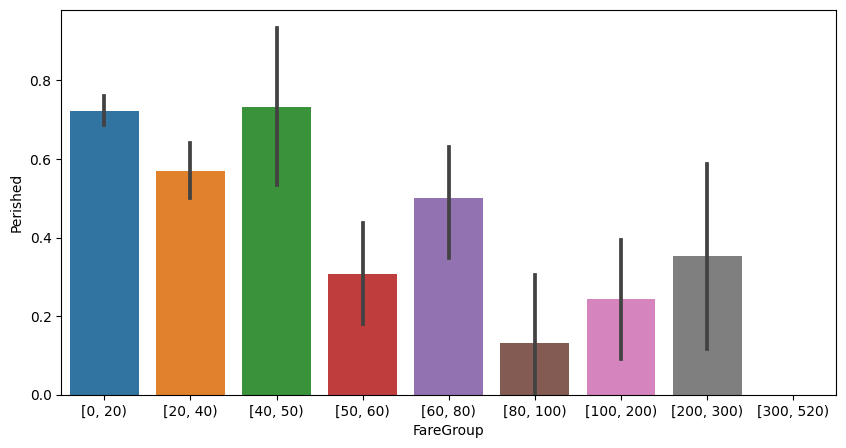

In [ ]:
# "FareGroup"別の死亡率
plt.figure(figsize=(10, 5))
sns.barplot(x="FareGroup", y="Perished", data=df)
plt.show()

知見  
・料金が低いと死亡率が高い

#### 2.2.13 "FareLabel"列

In [ ]:
# "Fare"別の死亡率でグループ分け
def fare_label(fare):
    if ((0 <= fare < 20) | (40 <= fare < 50)):
        return 0
    elif ((20 <= fare < 40) | (60 <= fare < 80)):
        return 1
    elif ((50 <= fare < 60) | (80 <= fare < 300)):
        return 2
    elif (fare >= 300):
        return 3

df["FareLabel"] = df["Fare"].apply(fare_label)
df_test["FareLabel"] = df_test["Fare"].apply(fare_label)
df_all["FareLabel"] = df_all["Fare"].apply(fare_label)

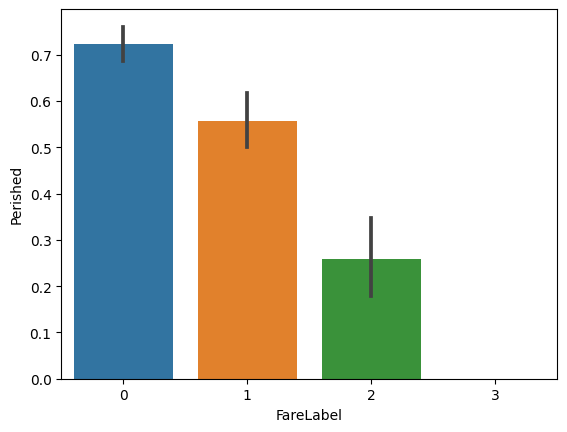

In [ ]:
# "FareLabel"別の死亡率
sns.barplot(x="FareLabel", y="Perished", data=df)
plt.show()

#### 2.2.14 "Deck"列

In [ ]:
# 客室番号の頭文字は上層からA-Gまで、Tは一人だけ
df["Deck"] = df["Cabin"].str.get(0)
df_test["Deck"] = df_test["Cabin"].str.get(0)
df_all["Deck"] = df_all["Cabin"].str.get(0)

In [ ]:
df_all["Deck"].value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Deck, dtype: int64

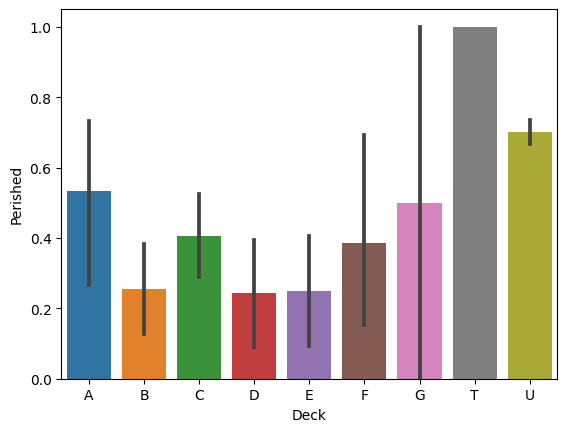

In [ ]:
# "Deck"別の死亡率
sns.barplot(x="Deck", y="Perished", data=df, order=["A", "B", "C", "D", "E", "F", "G", "T", "U"])
plt.show()

#### 2.2.15 "DeckLabel"列

In [ ]:
# "Deck"が"U"であるかどうかでグループ分け
def deck_label(deck):
    if (deck in ["U"]):
        return 0
    else:
        return 1

df["DeckLabel"] = df["Deck"].apply(deck_label)
df_test["DeckLabel"] = df_test["Deck"].apply(deck_label)
df_all["DeckLabel"] = df_all["Deck"].apply(deck_label)

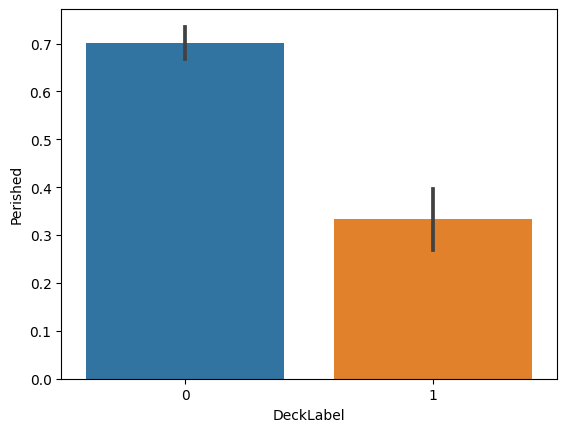

In [ ]:
# "DeckLabel"別の死亡率
sns.barplot(x="DeckLabel", y="Perished", data=df)
plt.show()

#### 2.1.16 "EmbarkedLabel"列

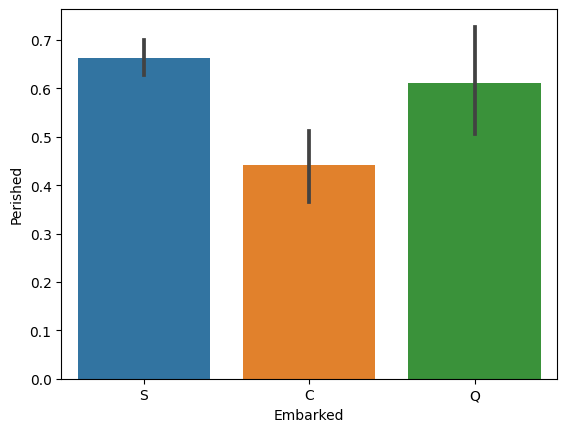

In [ ]:
# "Embarked"別の死亡率
sns.barplot(x="Embarked", y="Perished", data=df)
plt.show()

In [ ]:
# "Embarked"別の死亡率でグループ分け
def embarked_label(embarked):
    if (embarked in ["S", "Q"]):
        return 0
    elif (embarked in ["C"]):
        return 1

df["EmbarkedLabel"] = df["Embarked"].apply(embarked_label)
df_test["EmbarkedLabel"] = df_test["Embarked"].apply(embarked_label)
df_all["EmbarkedLabel"] = df_all["Embarked"].apply(embarked_label)

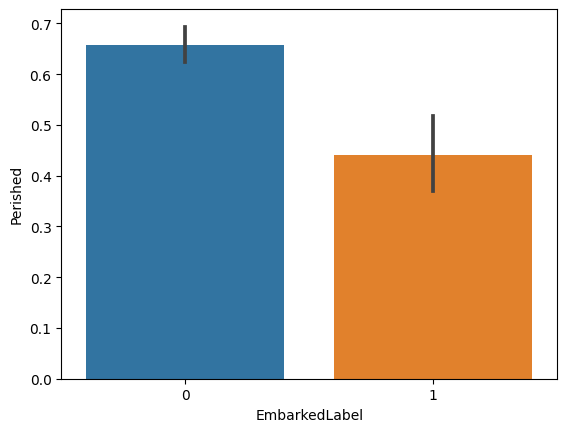

In [ ]:
# "EmbarkedLabel"別の死亡率
sns.barplot(x="EmbarkedLabel", y="Perished", data=df)
plt.show()

### 2.3 カテゴリカル変数に対しての処理

#### 2.3.1 "Sex"列

In [ ]:
# "Sex"列を二値化
df.replace({"Sex": {"male": 0, "female": 1}}, inplace=True)
df_test.replace({"Sex": {"male": 0, "female": 1}}, inplace=True)

#### 2.3.2 "Embarked"列

In [ ]:
# # "Embarked"列をOne-Hot Encoding
# embarked = pd.concat([df["Embarked"], df_test["Embarked"]])

# embarked_ohe = pd.get_dummies(embarked)

# embarked_ohe_train = embarked_ohe[:891]
# embarked_ohe_test = embarked_ohe[891:]

# df = pd.concat([df, embarked_ohe_train], axis=1)
# df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

#### 2.3.3 "Title"列

In [ ]:
# trainデータの敬称の種類と数
df["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [ ]:
# testデータの敬称の種類と数
df_test["Title"].value_counts()

Mr        254
Miss       80
Mrs        63
Master     15
Col         2
Ms          1
Rev         1
Dr          1
Dona        1
Name: Title, dtype: int64

In [ ]:
# "Title"別の死亡率（変更前）
df[["Title", "Perished"]].groupby(["Title"], as_index=True).mean().sort_values(by="Perished")

,Perished
Title,
Sir,0.000000
Ms,0.000000
Countess,0.000000
Mme,0.000000
Mlle,0.000000
Lady,0.000000
Mrs,0.208000
Miss,0.302198
Master,0.425000


In [ ]:
# 男性の敬称を"Mr"に統一
df["Title"] = df["Title"].replace(["Capt", "Col", "Don", "Major", "Rev", "Sir", "Jonkheer"], "Mr")
df_test["Title"] = df_test["Title"].replace(["Capt", "Col", "Don", "Major", "Rev", "Sir", "Jonkheer"], "Mr")

# 既婚女性（と思われる）の敬称を"Mrs"に統一
df["Title"] = df["Title"].replace(["Countess", "Mme"], "Mrs")
df_test["Title"] = df_test["Title"].replace(["Countess", "Mme"], "Mrs")

# 未婚女性（と思われる）の敬称を"Miss"に統一
df["Title"] = df["Title"].replace(["Dona", "Lady", "Mlle", "Ms"], "Miss")
df_test["Title"] = df_test["Title"].replace(["Dona", "Lady", "Mlle", "Ms"], "Miss")

In [ ]:
# "Title"別の死亡率（変更後）
df[["Title", "Perished"]].groupby(["Title"], as_index=True).mean().sort_values(by="Perished")

,Perished
Title,
Mrs,0.204724
Miss,0.295699
Master,0.425000
Dr,0.571429
Mr,0.841808


In [ ]:
# "Title"列をOne-Hot Encoding
title = pd.concat([df["Title"], df_test["Title"]])

title_ohe = pd.get_dummies(title)

title_ohe_train = title_ohe[:891]
title_ohe_test = title_ohe[891:]

df = pd.concat([df, title_ohe_train], axis=1)
df_test = pd.concat([df_test, title_ohe_test], axis=1)

#### 2.3.4 "Deck"列

In [ ]:
# # "Deck"列をOne-Hot Encoding
# deck = pd.concat([df["Deck"], df_test["Deck"]])

# deck_ohe = pd.get_dummies(deck)

# deck_ohe_train = deck_ohe[:891]
# deck_ohe_test = deck_ohe[891:]

# df = pd.concat([df, deck_ohe_train], axis=1)
# df_test = pd.concat([df_test, deck_ohe_test], axis=1)

# df.head()

### 2.4 特徴量の削除

In [ ]:
df.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Surname',
       'FamilyGroup', 'SibSpLabel', 'ParchLabel', 'FamilySize',
       'FamilySizeLabel', 'SameTicketGroup', 'SameTicketLabel', 'TicketLabel',
       'AgeGroup', 'FareGroup', 'FareLabel', 'Deck', 'DeckLabel',
       'EmbarkedLabel', 'Dr', 'Master', 'Miss', 'Mr', 'Mrs'],
      dtype='object')

In [ ]:
# 削除する特徴量
# ラベリングした特徴量は削除
# "TicketLabel"は過学習になりやすいため削除
# "Dr"はtestデータに1人しかいないため削除
# "Master"は削除したらスコアが上がった（trainデータとtestデータの死亡率に大きな差があると考えられる）
del_fe = ["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked", "Title", "Surname", "FamilyGroup", "FamilySize", "SameTicketGroup", "TicketLabel", "AgeGroup", "FareGroup", "Deck", "Dr", "Master"]

# 特徴量を削除
df.drop(del_fe, axis=1, inplace=True)
df_test.drop(del_fe, axis=1, inplace=True)

In [ ]:
df.isnull().sum()

PassengerId        0
Perished           0
Pclass             0
Sex                0
Age                0
SibSpLabel         0
ParchLabel         0
FamilySizeLabel    0
SameTicketLabel    0
FareLabel          0
DeckLabel          0
EmbarkedLabel      0
Miss               0
Mr                 0
Mrs                0
dtype: int64

In [ ]:
df_test.isnull().sum()

PassengerId        0
Pclass             0
Sex                0
Age                0
SibSpLabel         0
ParchLabel         0
FamilySizeLabel    0
SameTicketLabel    0
FareLabel          0
DeckLabel          0
EmbarkedLabel      0
Miss               0
Mr                 0
Mrs                0
dtype: int64

## 3\. ランダムフォレストモデル構築

### 3.1 変数の準備
- 説明変数：PassengerId, Perished以外の変数  
- 目的変数：Perished

In [ ]:
# X:説明変数  y:目的変数
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
X_test = df_test.iloc[:, 1:].values

### 3.2 グリッドサーチ（ホールドアウト法）

In [ ]:
# データ分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.6, random_state=42)

In [ ]:
# グリッドサーチするパラメータ
param_grid = {
    "max_depth": [5, 6, 7, 8],
    "min_samples_leaf": [3, 4, 5],
    "n_estimators": [i for i in range(10, 21, 2)]
}

In [ ]:
# グリッドサーチ（ホールドアウト法）
for max_depth in param_grid["max_depth"]:
    for min_samples_leaf in param_grid["min_samples_leaf"]:
        for n_estimators in param_grid["n_estimators"]:
            rfc_grid = RandomForestClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                n_estimators=n_estimators,
                n_jobs=-1,
                random_state=42
            )
            rfc_grid.fit(X_train, y_train)
            print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, n_estimators: {n_estimators}")
            print(f"    Train Score: {round(rfc_grid.score(X_train, y_train), 3)}, Test Score: {round(rfc_grid.score(X_valid, y_valid), 3)}")

max_depth: 5, min_samples_leaf: 3, n_estimators: 10
    Train Score: 0.826, Test Score: 0.819
max_depth: 5, min_samples_leaf: 3, n_estimators: 12
    Train Score: 0.837, Test Score: 0.815
max_depth: 5, min_samples_leaf: 3, n_estimators: 14
    Train Score: 0.826, Test Score: 0.821
max_depth: 5, min_samples_leaf: 3, n_estimators: 16
    Train Score: 0.834, Test Score: 0.822
max_depth: 5, min_samples_leaf: 3, n_estimators: 18
    Train Score: 0.831, Test Score: 0.821
max_depth: 5, min_samples_leaf: 3, n_estimators: 20
    Train Score: 0.826, Test Score: 0.826
max_depth: 5, min_samples_leaf: 4, n_estimators: 10
    Train Score: 0.817, Test Score: 0.809
max_depth: 5, min_samples_leaf: 4, n_estimators: 12
    Train Score: 0.817, Test Score: 0.815
max_depth: 5, min_samples_leaf: 4, n_estimators: 14
    Train Score: 0.826, Test Score: 0.821
max_depth: 5, min_samples_leaf: 4, n_estimators: 16
    Train Score: 0.831, Test Score: 0.832
max_depth: 5, min_samples_leaf: 4, n_estimators: 18
    Trai

In [ ]:
# 最適なモデル
# 上記の結果からスコアが高く、TrainとTestの差が小さいものを選ぶ
rfc_best = RandomForestClassifier(
    max_depth=7,
    min_samples_leaf=4,
    n_estimators=16,
    n_jobs=-1,
    random_state=42
)

rfc_best.fit(X, y)

# 正解率
print(f"Score: {round(rfc_best.score(X, y), 3)}")

Score: 0.855


### 3.3 グリッドサーチ（クロスバリデーション法）

In [ ]:
# # グリッドサーチするパラメータ
# param_grid = {
#     "max_depth": [5, 6, 7, 8],
#     "min_samples_leaf": [3, 4, 5],
#     "n_estimators": [50, 100, 200]
# }

In [ ]:
# # グリッドサーチ（クロスバリデーション法）
# rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
# rfc_gs = GridSearchCV(rfc, param_grid, cv=5, return_train_score=True)
# rfc_gs.fit(X, y)

# print(f"Best Parameters: {rfc_gs.best_params_}")
# print(f"CV Score: {round(rfc_gs.best_score_, 3)}")

In [ ]:
# # 最適なモデル
# rfc_best = RandomForestClassifier(
#     max_depth=rfc_gs.best_params_["max_depth"],
#     min_samples_leaf=rfc_gs.best_params_["min_samples_leaf"],
#     n_estimators=rfc_gs.best_params_["n_estimators"],
#     n_jobs=-1,
#     random_state=42
# )

# rfc_best.fit(X, y)

# # 正解率
# print(f"Score: {round(rfc_best.score(X, y), 3)}")

### 3.4 説明変数を絞る

In [ ]:
# # グリッドサーチするパラメータ
# param_grid = {
#     "classify__max_depth": [5, 6, 7, 8],
#     "classify__min_samples_leaf": [3, 4, 5],
#     "classify__n_estimators": [50, 100, 200]
# }

In [ ]:
# # 説明変数を12個に絞る
# select = SelectKBest(k=12)
# rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
# pipe = Pipeline([("select", select), ("classify", rfc)])

# rfc_gs = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, return_train_score=True)
# rfc_gs.fit(X, y)

# print(f"Best Parameters: {rfc_gs.best_params_}")
# print(f"CV Score: {round(rfc_gs.best_score_, 3)}")

In [ ]:
# # 最適なモデル
# rfc_best = RandomForestClassifier(
#     max_depth=rfc_gs.best_params_["classify__max_depth"],
#     min_samples_leaf=rfc_gs.best_params_["classify__min_samples_leaf"],
#     n_estimators=rfc_gs.best_params_["classify__n_estimators"],
#     n_jobs=-1,
#     random_state=42
# )

# rfc_best_pipeline = make_pipeline(select, rfc_best)
# rfc_best_pipeline.fit(X, y)

# cv_result = cross_validate(rfc_best_pipeline, X, y, cv=5)
# print(f"Mean Score: {np.mean(cv_result['test_score'])}")
# print(f"Std: {np.std(cv_result['test_score'])}")

# # 正解率
# print(f"Score: {round(rfc_best_pipeline.score(X, y), 3)}")

In [ ]:
# # 説明変数の採用可否
# mask = select.get_support()

# list_col = list(df.columns[2:])

# for i, j in enumerate(list_col):
#     print(f"No {i + 1}, {j} = {mask[i]}")

# X_selected = select.transform(X)
# print(f"X.shape = {X.shape}, X_selected.shape = {X_selected.shape}")

### 3.5 Optunaの利用

In [ ]:
# # 目的関数の設定（ステップ1）
# def objective(trial):
#     # ハイパーパラメータの集合を定義する
#     # 推定器の集合
#     classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])

#     # 推定器ごとのハイパーパラメータの集合
#     # ランダムフォレスト
#     if classifier_name == "RandomForest":
#         rf_max_depth = trial.suggest_int("rf_max_depth", 2, 10, log=True)
#         rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 2, 10)
#         rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 300)
#         classifier_obj = ensemble.RandomForestClassifier(max_depth=rf_max_depth, min_samples_leaf=rf_min_samples_leaf, n_estimators=rf_n_estimators)

#     # 良し悪しを判断するメトリクスを定義する
#     # CVの実施
#     score = model_selection.cross_val_score(classifier_obj, X, y, n_jobs=-1, cv=5)
#     ## CVの結果の平均値
#     accuracy = score.mean()
#     return accuracy

# # 目的関数の最適化を実行する（ステップ2）
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)

In [ ]:
# # 最適解の出力
# print(f"The best value is: {study.best_value}")
# print(f"The best parameters: {study.best_params}")

In [ ]:
# # 最適なモデル
# rfc_best = RandomForestClassifier(max_depth=study.best_params["rf_max_depth"], min_samples_leaf=study.best_params["rf_min_samples_leaf"], n_estimators=study.best_params["rf_n_estimators"], n_jobs=-1, random_state=42)
# rfc_best.fit(X, y)

# # 正解率
# print(f"Score: {round(rfc_best.score(X, y), 3)}")

## 4\. 提出ファイル作成

In [ ]:
# 予測結果
rfc_pred = rfc_best.predict_proba(X_test)
pred = rfc_pred.argmax(axis=1)

In [ ]:
# ファイルをセッションストレージにアップロード
submission = pd.read_csv("gender_submission.csv")

print(submission.shape)
print(pred.shape)

(418, 2)
(418,)


In [ ]:
submission["Perished"] = pred
submission.head()

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,0


In [ ]:
submission.to_csv("submission.csv", index=False)

## 参考文献
- https://qiita.com/shiroino11111/items/bc3889fa38ff32d46c13
- https://qiita.com/jun40vn/items/d8a1f71fae680589e05c
- https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy
- https://www.kaggle.com/code/lainguyn123/titantic-prediction-interpretable-ml